In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
import os
from sklearn.metrics import f1_score
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
from datetime import datetime
#from xgboost import XGBClassifier
import seaborn as sns


In [2]:
# Путь к директории с данными

data_dir = '../00_data/track_1/'
extra_data_dir =  '../00_data/1_track_extra_train/'
sumbit_dir = '../02_submits/'
preprocessed_dir = '../03_preprocessed_data/'

# Метео
mc = pd.read_csv(data_dir + 'meteo_coord.csv')
mld = pd.read_csv(extra_data_dir + 'meteo_1day.csv')
mlm = pd.read_csv(extra_data_dir + 'meteo_1month.csv')
#mld = pd.read_csv(data_dir + 'meteo_1day.csv')
#mlm = pd.read_csv(data_dir + 'meteo_1month.csv')
#m3h = pd.read_csv(data_dir + 'meteo_3hours.csv')
rhv = pd.read_csv(data_dir + 'reference_horiz_visib.csv')
main_df = pd.read_csv(data_dir + 'train.csv')
test = pd.read_csv(data_dir + 'test.csv')

# Гидро
hc = pd.read_csv(data_dir + 'hydro_coord.csv')
#hld = pd.read_csv(data_dir + 'hydro_1day.csv',
#                   parse_dates=['date'])
hld = pd.read_csv(extra_data_dir  + 'hydro_1day.csv',
                   parse_dates=['date'])
#h1d_extra = pd.read_csv(extra_data_dir + 'hydro_1day.csv',
#                   parse_dates=['date'])
spd = pd.read_pickle(extra_data_dir + 'statistics_per_day.pkl')
#hld = pd.contact([hld, h1d_extra])
rwc = pd.read_csv(data_dir + 'reference_water_codes.csv')
#os.listdir(data_dir)
all_pressure_data_level_1000 = pd.read_pickle(extra_data_dir + 'all_pressure_data_level_1000.pkl')

In [3]:
wc = pd.read_csv(data_dir + 'reference_water_codes.csv')

spd.sample()

,uwnd min,uwnd max,uwnd sum,uwnd mean,vwnd min,vwnd max,vwnd sum,vwnd mean,air min,air max,air sum,air mean,wind_speed min,wind_speed max,wind_speed sum,wind_speed mean
time,,,,,,,,,,,,,,,,
2009-11-19,-2.399994,5.550003,94.920273,2.636674,-2.429993,2.500015,45.080276,1.25223,248.000015,258.619995,9103.410278,252.872508,1.265913,5.625741,131.337997,3.648278


#### wc

In [4]:
# Проранжировать станции по течению реки
# 3019 Киренск
# 3027 Витим
# 3028 Пелендуй
# 3029 КРЕСТОВСКОЕ 
# 3030 ЛЕНСК 
# 3035 ОЛЕКМИНСК 
# 3041 ПОКРОВСК 
# 3045 ЯКУТСК 
# 3230 БАТАМАЙ 
# 3050 САНГАРЫ 

station_id_ordered = [3019, 3027, 3028, 3029, 3030, 3035, 3041, 3045,  3230, 3050]
station_id_rank = range(0, len(station_id_ordered))
station_id_rank = dict(zip(station_id_ordered, station_id_rank))

In [5]:
all_pressure_data_level_1000['station_id'] = all_pressure_data_level_1000['station_id'].astype(int)
all_pressure_data_level_1000 = all_pressure_data_level_1000.reset_index()
all_pressure_data_level_1000 = all_pressure_data_level_1000.drop(['lat', 'lon'], axis = 1)
all_pressure_data_level_1000['date']= all_pressure_data_level_1000['time'].dt.date.astype(str)
all_pressure_data_level_1000 = all_pressure_data_level_1000[all_pressure_data_level_1000['station_id'].isin(station_id_ordered)]

In [6]:
all_pressure_data_level_1000[(all_pressure_data_level_1000['station_id'] == 3019) &
(all_pressure_data_level_1000['date'] == '2015-06-01')]

,time,air,station_id,hgt,uwnd,vwnd,shum,rhum,omega,date
424284,2015-06-01 00:00:00,287.699982,3019,71.0,2.800002,2.600000,0.00764,74.0,0.082,2015-06-01
424285,2015-06-01 06:00:00,291.200012,3019,58.0,6.100001,0.900002,0.01098,85.0,-0.056,2015-06-01
424286,2015-06-01 12:00:00,289.399994,3019,53.0,4.700000,1.400002,0.01059,92.0,-0.093,2015-06-01
424287,2015-06-01 18:00:00,285.899994,3019,57.0,3.800000,2.100002,0.00907,99.0,-0.036,2015-06-01


In [7]:
all_pressure_data_level_1000['date']

0         1985-01-01
1         1985-01-01
2         1985-01-01
3         1985-01-01
4         1985-01-02
             ...    
517195    2021-05-25
517196    2021-05-26
517197    2021-05-26
517198    2021-05-26
517199    2021-05-26
Name: date, Length: 517200, dtype: object

# Гидрологические данные

In [8]:
#a = pd.concat([hld, hld['water_code'].str.split(',', expand=True)], axis=1)
#b = pd.get_dummies(a, columns=[0,1,2,3,4], drop_first=False).fillna(0)
#list(b.columns[14:])

In [9]:
#### hld.water_code.split()

hld = pd.concat([hld, hld['water_code'].str.split(',', expand=True)], axis=1)
hld[0] = hld[0].fillna(0)
#test_data[0].value_counts()

def phase(water_code):
    water_code = int(water_code)
    summer = [x for x in range(29,41)] + [52,53,60]
    autumn = [x for x in range(1,8)] + [13,41,42,45,51]
    winter = [x for x in range(14,23)] + [46,50]
    spring = 1
    if water_code in summer:
        return 0
    elif water_code in autumn:
        return 1
    elif water_code in winter:
        return 2
    else:
        return 3

hld['phase'] = hld[0].apply(lambda x: phase(x))

hld = pd.get_dummies(hld, columns=[0,1,2,3,4,'phase'], drop_first=False).fillna(0)

hld['water_code_0'] = hld[['0_0']].max(axis=1)
hld['water_code_1'] = hld[['0_1', '1_ 1', '2_ 1']].max(axis=1)
hld['water_code_2'] = hld[['0_2',  '1_ 2',  '2_ 2',  '3_ 2']].max(axis=1)
hld['water_code_3'] = hld[['0_3']].max(axis=1)
hld['water_code_4'] = hld[['0_4', '1_ 4', '2_ 4']].max(axis=1)
hld['water_code_5'] = hld[['0_5', '1_ 5']].max(axis=1)
hld['water_code_6'] = hld[['0_6',  '1_ 6']].max(axis=1)
hld['water_code_7'] = hld[['0_7']].max(axis=1)
hld['water_code_8'] = hld[['0_8',  '1_ 8', '2_ 8', '3_ 8']].max(axis=1)
hld['water_code_9'] = hld[['0_9',  '1_ 9', '2_ 9']].max(axis=1)
hld['water_code_10'] = hld[['1_10']].max(axis=1)
hld['water_code_12'] = hld[['0_12', '1_12']].max(axis=1)
hld['water_code_13'] = hld[['0_13', '1_13', '2_13']].max(axis=1)
hld['water_code_14'] = hld[['0_14', '1_14', '2_14', '3_14']].max(axis=1)
hld['water_code_15'] = hld[['0_15','1_15', '2_15','3_15', '4_15']].max(axis=1)
hld['water_code_16'] = hld[['0_16', '1_16', '2_16', '3_16', '4_16']].max(axis=1)
hld['water_code_17'] = hld[['0_17']].max(axis=1)
hld['water_code_18'] = hld[['0_18', '1_18', '2_18']].max(axis=1)
hld['water_code_21'] = hld[['0_21', '1_21', '2_21']].max(axis=1)
hld['water_code_22'] = hld[['0_22', '1_22']].max(axis=1)
hld['water_code_23'] = hld[['0_23', '1_23', '2_23', '3_23']].max(axis=1)
hld['water_code_24'] = hld[['0_24', '1_24', '2_24']].max(axis=1)                                         

hld['water_code_25'] = hld[['0_25', '1_25', '4_25', '3_25', '2_25']].max(axis=1)    
hld['water_code_26'] = hld[['0_26', '1_26', '4_26', '3_26', '2_26']].max(axis=1)
hld['water_code_27'] = hld[['0_27', '1_27', '2_27', '3_27', '4_27']].max(axis=1)
hld['water_code_28'] = hld[['0_28', '1_28', '2_28']].max(axis=1)
hld['water_code_29'] = hld[['0_29',  '1_29', '2_29']].max(axis=1)
hld['water_code_34'] = hld[['0_34',  '1_34', '2_34', '3_34', '4_34']].max(axis=1)
hld['water_code_36'] = hld[['0_36']].max(axis=1)
hld['water_code_38'] = hld[['1_38', '2_38']].max(axis=1)                                        
hld['water_code_39'] = hld[['1_39']].max(axis=1)                                        

hld['water_code_41'] = hld[['0_41']].max(axis=1)
hld['water_code_42'] = hld[['0_42']].max(axis=1)
hld['water_code_46'] = hld[['0_46', '1_46', '3_46']].max(axis=1)
hld['water_code_47'] = hld[['0_47', '1_47', '2_47', '3_47']].max(axis=1)
hld['water_code_48'] = hld[['1_48', '0_48']].max(axis=1)   
hld['water_code_49'] = hld[['0_49', '1_49']].max(axis=1)                                         
                                         
                                         
hld['water_code_50'] = hld[['0_50',  '1_50']].max(axis=1)
hld['water_code_51'] = hld[['2_51']].max(axis=1)
hld['water_code_51'] = hld[['1_60']].max(axis=1)                                        
                                         



 

In [10]:
hld.drop(['0_1', '1_ 1', '2_ 1',
              '0_2',  '1_ 2',  '2_ 2',  '3_ 2',
               '0_3','0_4', '1_ 4',
               '0_5', '1_ 5',
               '0_6',  '1_ 6',
               '0_7', '0_8',  '1_ 8',
               '0_9',  '1_ 9',
               '1_10', '0_12', '1_13', '0_14', '1_14', '0_15','1_15', '2_15',
               '0_16', '1_16', '0_17',  '0_18', '1_18',
               '1_21', '0_22', '0_23', '0_27', '1_27',  '2_27',
               '0_28', '0_29',  '1_29', '2_29', '0_34',  '1_34', '0_36', 
               '0_41',  '0_42', '0_46', '1_46','1_47', '0_50',  '1_50', '2_51',
'0_0',
 '0_1',
 '0_11',
 '0_12',
 '0_13',
 '0_14',
 '0_15',
 '0_16',
 '0_17',
 '0_18',
 '0_2',
 '0_21',
 '0_22',
 '0_23',
 '0_24',
 '0_25',
 '0_26',
 '0_27',
 '0_28',
 '0_29',
 '0_3',
 '0_34',
 '0_36',
 '0_4',
 '0_41',
 '0_42',
 '0_46',
 '0_47',
 '0_48',
 '0_49',
 '0_5',
 '0_50',
 '0_6',
 '0_7',
 '0_8',
 '0_9',
 '1_ 1',
 '1_ 2',
 '1_ 4',
 '1_ 5',
 '1_ 6',
 '1_ 8',
 '1_ 9',
 '1_10',
 '1_12',
 '1_13',
 '1_14',
 '1_15',
 '1_16',
 '1_17',
 '1_18',
 '1_21',
 '1_22',
 '1_23',
 '1_24',
 '1_25',
 '1_26',
 '1_27',
 '1_28',
 '1_29',
 '1_34',
 '1_38',
 '1_39',
 '1_46',
 '1_47',
 '1_48',
 '1_49',
 '1_50',
 '1_60',
 '2_ 1',
 '2_ 2',
 '2_ 4',
 '2_ 8',
 '2_ 9',
 '2_13',
 '2_14',
 '2_15',
 '2_16',
 '2_18',
 '2_21',
 '2_23',
 '2_24',
 '2_25',
 '2_26',
 '2_27',
 '2_28',
 '2_29',
 '2_34',
 '2_38',
 '2_47',
 '2_51',
 '3_ 2',
 '3_ 8',
 '3_14',
 '3_15',
 '3_16',
 '3_23',
 '3_25',
 '3_26',
 '3_27',
 '3_34',
 '3_46',
 '3_47',
 '4_15',
 '4_16',
 '4_25',
 '4_26',
 '4_27',
 '4_34'                 
                ],1,inplace=True)


In [11]:
hld.drop(['water_code'],inplace=True,axis=1)

In [12]:
hld

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51
0,2000,3019,1,1,2000-01-01,74.0,74.0,74.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,2000,3019,1,2,2000-01-02,70.0,70.0,70.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2000,3019,1,3,2000-01-03,67.0,67.0,67.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,2000,3019,1,4,2000-01-04,64.0,64.0,64.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2000,3019,1,5,2000-01-05,60.0,60.0,60.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234133,1991,3106,7,208,1991-07-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6920.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234134,1991,3106,7,209,1991-07-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4840.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234135,1991,3106,7,210,1991-07-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3780.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
234136,1991,3106,7,211,1991-07-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3130.0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

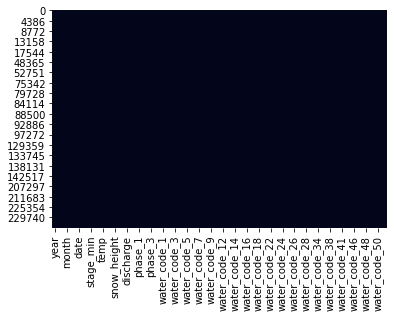

In [13]:
hld = hld[hld['station_id'].isin(station_id_ordered)]

sns.heatmap(hld.isnull(), cbar=False)

В летние месяцы заполнить толщину льда и высоту снена нулем. В остальные дни сделать интерполяцию по дате для каждой станции.

In [14]:
months_with_ice = hld.loc[ hld['ice_thickness'] > 0, 'month'].unique()
hld.loc[~(hld['month'].isin(months_with_ice)), 'ice_thickness'] = 0
hld.loc[~(hld['month'].isin(months_with_ice)), 'snow_height'] = 0
hld = hld.sort_values(['station_id', 'year', 'day'])
hld[['ice_thickness', 'snow_height']] = hld.\
    groupby('station_id')['ice_thickness',  'snow_height'].\
    apply(lambda group: group.interpolate(method='index'))

/home/raxel/.local/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-14-d997c72e128f>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  hld[['ice_thickness', 'snow_height']] = hld.\


In [15]:
hld[['ice_thickness', 'snow_height']] = hld[['ice_thickness', 'snow_height']].fillna(method='bfill', limit=20)

Пропущенную температуру воды заполним нулем

In [16]:
hld['temp'] = hld['temp'].fillna(0)

Place заполнить нулем в летние месяцы и паддингом назад в остальные

In [17]:
hld.loc[~(hld['month'].isin(months_with_ice)), 'place'] = 0
hld['place'] = hld['place'].fillna(method='bfill', limit=20)

<AxesSubplot:xlabel='date'>

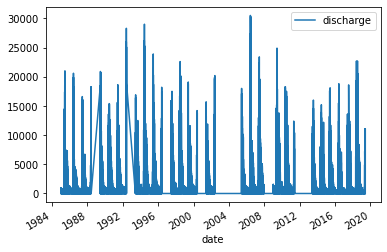

In [18]:
hld.plot('date','discharge')

# Метеорологические данные

<AxesSubplot:>

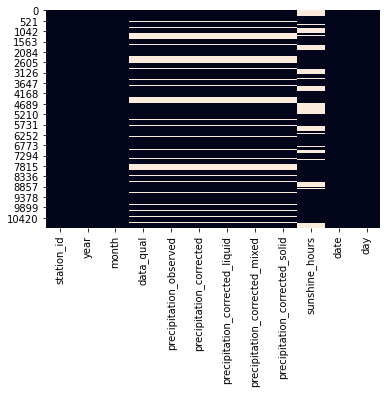

In [19]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])

sns.heatmap(mlm.isnull(), cbar=False)

In [20]:
mlm = mlm.sort_values(['station_id', 'year', 'month'])
num_cols = ['precipitation_observed',
            'precipitation_corrected', 
            'precipitation_corrected_liquid',
           'precipitation_corrected_mixed',
           'precipitation_corrected_solid',
           'sunshine_hours']

mlm[num_cols] = mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index')).drop('station_id', axis = 1)

#mlm[num_cols].replace(9999, np.nan)

for col in num_cols:
    mlm.loc[mlm[col] == 9999.9, [col]] = np.nan


In [21]:
mlm[num_cols + ['station_id']].groupby('station_id').\
    apply(lambda group: group.interpolate(method='index'))

,precipitation_observed,precipitation_corrected,precipitation_corrected_liquid,precipitation_corrected_mixed,precipitation_corrected_solid,sunshine_hours,station_id
0,3.8,5.7,0.0,0.0,5.7,NaN,24538
1,3.6,5.2,0.0,0.0,5.2,NaN,24538
2,9.9,14.5,0.0,0.0,14.5,NaN,24538
3,6.4,7.8,0.0,0.2,7.6,NaN,24538
4,6.7,9.1,7.8,0.8,0.5,NaN,24538
...,...,...,...,...,...,...,...
10921,18.3,17.5,0.0,0.0,17.5,NaN,31137
10922,16.3,14.4,0.0,0.0,14.4,NaN,31137
10923,26.8,25.0,0.0,0.0,25.0,NaN,31137
10924,42.4,41.6,3.2,3.3,35.1,NaN,31137


In [22]:
mlm = mlm.fillna(method='bfill', limit=20)
for col in num_cols:
    mlm[col] = mlm[col].fillna(0)

In [23]:
#mld = mld.sort_values(['station_id', 'year', 'month'])

#sns.heatmap(mld.isnull(), cbar=False)

In [24]:
# sns.heatmap(mlm.isnull(), cbar=False)

In [25]:
# sns.heatmap(m3h.isnull(), cbar=False)

In [26]:
# соединим train и test, чтобы фичи генерировались и на тесте тоже
main_df = pd.concat([main_df, test])
main_df['is_test'] = main_df['ice_jam'].isnull()
main_df['station_rank'] = main_df['station_id']
main_df = main_df.replace({"station_rank": station_id_rank})

### Затор в прошлом году в тот же день

In [27]:
main_df['previous_year'] = main_df['year'] - 1
X = main_df.merge(main_df, 
              how = 'left', 
              left_on = ['previous_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['previous_year_x', 'previous_year_y', 'year_y', 'is_test_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_last_year'              
                              })
main_df = main_df.drop('previous_year', axis = 1)
X.head()

,year,station_id,day,ice_jam,is_test_x,station_rank_x,ice_jam_same_day_last_year,station_rank_y
0,2000,3019,1,0.0,False,0,0.0,0.0
1,2000,3019,2,0.0,False,0,0.0,0.0
2,2000,3019,3,0.0,False,0,0.0,0.0
3,2000,3019,4,0.0,False,0,0.0,0.0
4,2000,3019,5,0.0,False,0,0.0,0.0


### Затор в позапрошлом году в тот же день

In [28]:
X['preprevious_year'] = X['year'] - 2
X = X.merge(main_df.drop('is_test', axis = 1),
              how = 'left', 
              left_on = ['preprevious_year', 'day', 'station_id'],
              right_on = ['year', 'day', 'station_id']
             ).drop(['preprevious_year', 'year_y'], axis =1
                   ).rename(columns={'year_x':'year', 
                 'ice_jam_x':'ice_jam',
                 'ice_jam_y':'ice_jam_same_day_prelast_year',
                 'is_test_x':'is_test'
                              })
X.head()

,year,station_id,day,ice_jam,is_test,station_rank_x,ice_jam_same_day_last_year,station_rank_y,ice_jam_same_day_prelast_year,station_rank
0,2000,3019,1,0.0,False,0,0.0,0.0,NaN,NaN
1,2000,3019,2,0.0,False,0,0.0,0.0,NaN,NaN
2,2000,3019,3,0.0,False,0,0.0,0.0,NaN,NaN
3,2000,3019,4,0.0,False,0,0.0,0.0,NaN,NaN
4,2000,3019,5,0.0,False,0,0.0,0.0,NaN,NaN


### Индикатор - есть ли данные по заторам за прошлый год

In [29]:
X['is_last_year_missing'] = X['ice_jam_same_day_last_year'].isnull()
X['is_prelast_year_missing'] = X['ice_jam_same_day_prelast_year'].isnull()
X = X.fillna(0)

### Количество заторов в прошлом году

In [30]:
X[['n_jams_last_year','n_jams_prelast_year']] = \
    X.groupby(['year', 'station_id'])[['ice_jam_same_day_last_year', 'ice_jam_same_day_prelast_year']]\
    .transform('sum')

## Количество заторов в прошлом по всем годам

In [31]:
ice_jams_per_year = X.groupby(['year', 'station_id'])['ice_jam'].sum().reset_index().drop_duplicates()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year.sort_values(by = 'year').\
    groupby(['station_id'])['ice_jam'].cumsum()
ice_jams_per_year['n_jams_past'] = ice_jams_per_year['n_jams_past'] - ice_jams_per_year['ice_jam']
ice_jams_per_year = ice_jams_per_year.drop('ice_jam', axis = 1)
X = X.merge(ice_jams_per_year, how = 'left', on = ['year', 'station_id'])

In [32]:
# n_same_days_before: how many days are available in the past for a given date
X['n_same_days_before'] = X[['year', 'day', 'station_id']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    .cumcount()
X['n_ice_jams_same_days_before'] = X[['year', 'day', 'station_id', 'ice_jam']] \
    .sort_values(by = ['year', 'day']) \
    .groupby(['station_id', 'day']) \
    ['ice_jam']\
    .cumsum()
X['n_ice_jams_same_days_before'] = X['n_ice_jams_same_days_before'] - X['ice_jam']
X['n_ice_jams_same_days_before_ratio'] = X['n_ice_jams_same_days_before']/X['n_same_days_before']
X = X.fillna(0)

## Разбиение по годам

In [33]:
# Суммарное количество заторов в году
jams_by_year = main_df.groupby('year').sum()['ice_jam'].to_frame().reset_index()
jams_by_year['ice_jam'].describe()

count    35.000000
mean      3.942857
std       4.014260
min       0.000000
25%       0.000000
50%       3.000000
75%       6.000000
max      16.000000
Name: ice_jam, dtype: float64

In [34]:
# Разделим на бины по квартилям
bins = [-1, 3, 5, 8, 16]
jams_by_year['ice_jam_bins'] = pd.cut(jams_by_year['ice_jam'], bins)
X_length = jams_by_year[['year', 'ice_jam']]
y_length = jams_by_year['ice_jam_bins']
y_length.value_counts()

(-1, 3]    18
(3, 5]      7
(5, 8]      6
(8, 16]     4
Name: ice_jam_bins, dtype: int64

In [35]:
# Разделим годы на трейн и тест
X_train, X_test, y_train, y_test = train_test_split(X_length, 
                                                    y_length, 
                                                    test_size=0.3,  
                                                    stratify=y_length, 
                                                    random_state=42)

### Feature description

**is_test**:  if is_test = 1 then the row belongs to the test dataset \
**ice_jam_same_day_last_year**: 1 if there were and ice jam on the same day last year \
**ice_jam_same_day_prelast_year**: 1 if there were and ice jam on the same day 2 years ago \
**is_last_year_missing**: 1 is the same day is missing last year \
**is_prelast_year_missing**: 1 is the same day is missing 2 years ago \
**n_jams_last_year**: number of jams last year at the station \
**n_jams_past**: number of jams in the past available data at the station \
**n_same_days_before**: number of same days available in the past \
**n_ice_jams_same_days_before**: number of ice jams ob the same day in the past \
**n_ice_jams_same_days_before_ratio**: n_ice_jams_same_days_before/n_ice_jams_same_days_before

### Соберем фичи из гидроданных

<div class="alert alert-block alert-warning">
Мы не можем использовать данные из будущего: всё, что происходит после заторного периода, относится уже к следующему году.
</div>

In [36]:
# Внесем не темпоральные данные
X = pd.merge(X, hc[['station_id', 
                                'distance_from_source', 
                                'drainage_area', 
                                'z_null']], on='station_id', how='left')

# Возьмем также данные из ежедневных наблюдений
hld.head(1)

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51
4902,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [37]:
# добавим реанализ к гидро данным
hld['date']= hld['date'].astype(str)
hld = hld.merge(all_pressure_data_level_1000.drop('time', axis = 1), on=['station_id', 'date'], how='left')
hld.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51,air,hgt,uwnd,vwnd,shum,rhum,omega
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.700012,278.0,2.500015,1.200012,0.00092,86.000015,0.033998


In [38]:
def replace_incorrect_or_missing_values(dataframe):
    # Находим колонки с признаками достоверности
    for col in list(dataframe.filter(regex='qual')):
        col_to_replace = col.rstrip(r'_qual')
        dataframe.loc[dataframe[col] != 0.0, [col_to_replace]] = np.nan
        #dataframe[col_to_replace][dataframe[col] == 9.0] =  np.nan
        dataframe = dataframe.drop(col, 1)
    return dataframe

mld = replace_incorrect_or_missing_values(mld)
mld 

,station_id,year,month,day,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_40cm,temperature_80cm,temperature_120cm,temperature_160cm,temperature_240cm,temperature_320cm,temperature_ks_5cm,temperature_ks_10cm,temperature_ks_15cm,temperature_ks_20cm,date,target_year
0,24538,1985,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-01,1985
1,24538,1985,1,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-02,1985
2,24538,1985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-03,1985
3,24538,1985,1,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-04,1985
4,24538,1985,1,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985-01-05,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346125,31137,2019,5,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-30,2019
346126,31137,2019,5,151,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-31,2019
346127,31137,2019,6,152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-01,2019
346128,31137,2019,6,153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-02,2019


In [39]:

#hld['station_id'] = hld['station_id'].astype(int)
#mld['station_id'] = mld['station_id'].astype(int)

In [40]:
# Подтянем ближайшую к гидростанции метеостанцию

from geopy.distance import geodesic
import re

def merge_coord(df):
    df['lat_long'] = df[['lat', 'lon']].apply(tuple, axis=1)
    return df

def stat_km(point, stat_list):
    stations_list=stat_list
    lst=[]
    if pd.isnull(point):
        lst.append(np.nan)
    else:
        for i in stations_list['lat_long']:
            x=geodesic(point, i).km
            lst.append(x)
            stations_list['dist']=pd.DataFrame(lst)
        y=stations_list['station_id'][stations_list['dist'] == stations_list['dist'].min()]
        y=y.to_string()
        y=re.sub("^[0-9]+", "", y)
        y=re.sub(" +", "", y)
        return int(y)

hc = merge_coord(hc)
mc = merge_coord(mc)
hc['closest_hydro'] = mc.lat_long.apply(lambda x: stat_km(x, mc))
mld = mld.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mld.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mld.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [41]:
hld

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51,air,hgt,uwnd,vwnd,shum,rhum,omega
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.700012,278.0,2.500015,1.200012,0.00092,86.000015,0.033998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
357393,2018,3230,12,364,2018-12-30,244.0,244.0,244.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,247.699997,224.0,5.400000,1.000002,0.00047,95.000000,-0.066000
357394,2018,3230,12,365,2018-12-31,242.0,242.0,242.0,0.0,86.0,6.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,252.399979,190.0,2.900000,-1.300000,0.00059,79.000000,-0.087000
357395,2018,3230,12,365,2018-12-31,242.0,242.0,242.0,0.0,86.0,6.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,250.499969,201.0,4.500001,-2.200000,0.00063,100.000000,-0.048000
357396,2018,3230,12,365,2018-12-31,242.0,242.0,242.0,0.0,86.0,6.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,245.199982,214.0,4.200000,1.200000,0.00025,62.000000,-0.091000


In [42]:
# добавим месячные данный по метероологии
mlm = mlm.merge(hc[['station_id', 'closest_hydro']], left_on=['station_id'], 
                right_on='closest_hydro', how='right')
mlm.drop(['station_id_x', 'closest_hydro', 'date'], axis=1, inplace=True)
mlm.rename({'station_id_y': 'station_id'}, axis=1, inplace=True)

In [43]:
mlm['data_qual'] = mlm['data_qual'].fillna(10)

In [44]:
mlm['missing_sunshine_hours'] = mlm['sunshine_hours'].isnull()
mlm['sunshine_hours'] = mlm['sunshine_hours'].fillna(0)

In [45]:
hld = hld.merge(mld, on=['station_id', 'year', 'month', 'day'], how='inner')
#hld = hld.fillna(0)

In [46]:
hld

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height_x,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51,air,hgt,uwnd,vwnd,shum,rhum,omega,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height_y,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_40cm,temperature_80cm,temperature_120cm,temperature_160cm,temperature_240cm,temperature_320cm,temperature_ks_5cm,temperature_ks_10cm,temperature_ks_15cm,temperature_ks_20cm,target_year
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.700012,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337433,2005,3230,12,364,2005-12-30,266.0,266.0,266.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,237.100006,232.0,-2.399994,2.200012,0.00019,100.000015,0.009998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006
337434,2005,3230,12,365,2005-12-31,264.0,264.0,264.0,0.0,63.0,23.0,1.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,239.500015,218.0,-2.699997,3.000015,0.00016,70.000015,0.051998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [47]:
hld.head()

,year,station_id,month,day,date,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height_x,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51,air,hgt,uwnd,vwnd,shum,rhum,omega,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height_y,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_40cm,temperature_80cm,temperature_120cm,temperature_160cm,temperature_240cm,temperature_320cm,temperature_ks_5cm,temperature_ks_10cm,temperature_ks_15cm,temperature_ks_20cm,target_year
0,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
1,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
2,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
3,1985,3019,1,1,1985-01-01,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
4,1985,3019,1,2,1985-01-02,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.700012,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985


### Скорректируем год, в который доступно наблюдение

In [48]:
# Определим для наблюдения год, в который оно доступно

# Маска-окно между заторным периодом и концом года
# true if after jam
# false otherwise
def after_jam_window(row, local=False):
    if local:
        month = row.month_local
        day = row.date_local.day
    else:
        month = row.month
        day = row.date.day
    return (((month == 6) and (day > 3))
            or (month in [7, 8, 9, 10, 11, 12]))

# Год относительно бизнес-логики
def target_year(row, local=False):
    if local:
        year = row.year_local
    else:
        year = row.year
    if after_jam_window(row):
        return year + 1
    else:
        return year

hld['date'] = pd.to_datetime(hld['date'], format='%Y-%m-%d')
hld['target_year'] = hld.apply(target_year, axis=1)

# Календарный год и день больше не нужны
hld.drop(columns=['year', 'date', 'day'], axis=1, inplace=True)

In [49]:
hld.head()

,station_id,month,stage_avg,stage_min,stage_max,temp,ice_thickness,snow_height_x,place,discharge,phase_0,phase_1,phase_2,phase_3,water_code_0,water_code_1,water_code_2,water_code_3,water_code_4,water_code_5,water_code_6,water_code_7,water_code_8,water_code_9,water_code_10,water_code_12,water_code_13,water_code_14,water_code_15,water_code_16,water_code_17,water_code_18,water_code_21,water_code_22,water_code_23,water_code_24,water_code_25,water_code_26,water_code_27,water_code_28,water_code_29,water_code_34,water_code_36,water_code_38,water_code_39,water_code_41,water_code_42,water_code_46,water_code_47,water_code_48,water_code_49,water_code_50,water_code_51,air,hgt,uwnd,vwnd,shum,rhum,omega,route_type,snow_coverage_near_station,snow_coverage_route,ice_crust_route,snow_height_aver,snow_height_max,snow_height_min,snow_density_aver,ice_crust_aver,snow_saturated_thickness,water_thickness,water_in_snow,water_total,snow_coverage_charact,snow_charact,snow_height_y,snow_coverage_station,snow_height_q1,snow_height_q2,snow_height_q3,temperature_20cm,temperature_40cm,temperature_80cm,temperature_120cm,temperature_160cm,temperature_240cm,temperature_320cm,temperature_ks_5cm,temperature_ks_10cm,temperature_ks_15cm,temperature_ks_20cm,target_year
0,3019,1,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.500000,226.0,0.100006,1.600006,0.00098,94.000015,0.054998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
1,3019,1,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255.400009,230.0,1.400009,3.500015,0.00096,100.000015,0.066998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
2,3019,1,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,257.000000,246.0,-1.099991,3.400009,0.00109,100.000015,0.036999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
3,3019,1,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,258.799988,258.0,-0.199997,2.300003,0.00121,96.000015,0.007998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985
4,3019,1,-23.0,-23.0,-23.0,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,256.700012,278.0,2.500015,1.200012,0.00092,86.000015,0.033998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,10.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985


In [50]:
# Гидро – сделаем ресэмплинг по месяцу

index = ['station_id', 'month', 'target_year']
cat_col = ['place']

hld_mean = hld.drop(cat_col, axis = 1).groupby(index).mean().add_prefix('mean_').reset_index()
hld_max = hld.drop(cat_col, axis = 1).groupby(index).max().add_prefix('max_').reset_index()
hld_min = hld.drop(cat_col, axis = 1).groupby(index).min().add_prefix('min_').reset_index()
hld_std = hld.drop(cat_col, axis = 1).groupby(index).std().add_prefix('std_').reset_index()
h1d_cat = hld[index + cat_col].groupby(index).median().add_prefix('median_').reset_index()

data_frames = [hld_mean, hld_max, hld_min, hld_std, h1d_cat]

hydro_monthly = pd.concat(data_frames, axis=1)
hydro_monthly = hydro_monthly.loc[:,~hydro_monthly.columns.duplicated()]
hydro_monthly.sort_values(index).head()

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_discharge,mean_phase_0,mean_phase_1,mean_phase_2,mean_phase_3,mean_water_code_0,mean_water_code_1,mean_water_code_2,mean_water_code_3,mean_water_code_4,mean_water_code_5,mean_water_code_6,mean_water_code_7,mean_water_code_8,mean_water_code_9,mean_water_code_10,mean_water_code_12,mean_water_code_13,mean_water_code_14,mean_water_code_15,mean_water_code_16,mean_water_code_17,mean_water_code_18,mean_water_code_21,mean_water_code_22,mean_water_code_23,mean_water_code_24,mean_water_code_25,mean_water_code_26,mean_water_code_27,mean_water_code_28,mean_water_code_29,mean_water_code_34,mean_water_code_36,mean_water_code_38,mean_water_code_39,mean_water_code_41,mean_water_code_42,mean_water_code_46,mean_water_code_47,mean_water_code_48,mean_water_code_49,mean_water_code_50,mean_water_code_51,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_route_type,mean_snow_coverage_near_station,mean_snow_coverage_route,mean_ice_crust_route,mean_snow_height_aver,mean_snow_height_max,mean_snow_height_min,mean_snow_density_aver,mean_ice_crust_aver,mean_snow_saturated_thickness,mean_water_thickness,mean_water_in_snow,mean_water_total,mean_snow_coverage_charact,mean_snow_charact,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,mean_temperature_20cm,mean_temperature_40cm,mean_temperature_80cm,mean_temperature_120cm,mean_temperature_160cm,mean_temperature_240cm,mean_temperature_320cm,mean_temperature_ks_5cm,mean_temperature_ks_10cm,mean_temperature_ks_15cm,mean_temperature_ks_20cm,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_ice_thickness,max_snow_height_x,max_discharge,max_phase_0,max_phase_1,max_phase_2,max_phase_3,max_water_code_0,max_water_code_1,max_water_code_2,max_water_code_3,max_water_code_4,max_water_code_5,max_water_code_6,max_water_code_7,max_water_code_8,max_water_code_9,max_water_code_10,max_water_code_12,max_water_code_13,max_water_code_14,max_water_code_15,max_water_code_16,max_water_code_17,max_water_code_18,max_water_code_21,max_water_code_22,max_water_code_23,max_water_code_24,max_water_code_25,max_water_code_26,max_water_code_27,max_water_code_28,max_water_code_29,max_water_code_34,max_water_code_36,max_water_code_38,max_water_code_39,max_water_code_41,max_water_code_42,max_water_code_46,max_water_code_47,max_water_code_48,max_water_code_49,max_water_code_50,max_water_code_51,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_route_type,max_snow_coverage_near_station,max_snow_coverage_route,max_ice_crust_route,max_snow_height_aver,max_snow_height_max,max_snow_height_min,max_snow_density_aver,max_ice_crust_aver,max_snow_saturated_thickness,max_water_thickness,max_water_in_snow,max_water_total,max_snow_coverage_charact,max_snow_charact,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,max_temperature_20cm,max_temperature_40cm,max_temperature_80cm,max_temperature_120cm,max_temperature_160cm,max_temperature_240cm,max_temperature_320cm,max_temperature_ks_5cm,max_temperature_ks_10cm,max_temperature_ks_15cm,max_temperature_ks_20cm,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_ice_thickness,min_snow_height_x,min_discharge,min_phase_0,min_phase_1,min_phase_2,min_phase_3,min_water_code_0,min_water_code_1,min_water_code_2,min_water_code_3,min_water_code_4,min_water_code_5,min_water_code_6,min_water_code_7,min_water_code_8,min_water_code_9,min_water_code_10,min_water_code_12,min_water_code_13,min_water_code_14,min_water_code_15,min_water_code_16,min_water_code_17,min_water_code_18,min_water_code_21,min_water_code_22,min_water_code_23,min_water_code_24,min_water_code_25,min_water_code_26,min_water_code_27,min_water_code_28,min_water_code_29,min_water_code_34,min_water_code_36,min_water_code_38,min_water_code_39,min_water_code_41,min_water_code_42,min_water_cod

In [51]:
hydro_monthly.loc[hydro_monthly['station_id'] == 3019,  ['station_id', 'target_year', 'month', 'mean_omega', 'max_omega', 'min_omega', 'std_omega']]

,station_id,target_year,month,mean_omega,max_omega,min_omega,std_omega
0,3019,1985,1,0.028546,0.135998,-0.120003,0.049855
1,3019,1986,1,-0.005333,0.114998,-0.163002,0.054057
2,3019,1987,1,0.015554,0.169998,-0.139002,0.057302
3,3019,1988,1,0.004498,0.111998,-0.113003,0.052356
4,3019,1990,1,0.020885,0.117998,-0.062002,0.043408
...,...,...,...,...,...,...,...
290,3019,2015,12,0.009726,0.123000,-0.103000,0.048858
291,3019,2016,12,0.028927,0.143000,-0.107000,0.048535
292,3019,2017,12,0.017831,0.119000,-0.084000,0.047351
293,3019,2018,12,0.023613,0.133000,-0.124000,0.056454


## Удалить колонки, где пропущено более 20%

In [52]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_drop = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > .2, 'column'].to_list()
hydro_monthly = hydro_monthly.drop(columns_to_drop, axis = 1)
hydro_monthly.head()


,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_discharge,mean_phase_0,mean_phase_1,mean_phase_2,mean_phase_3,mean_water_code_0,mean_water_code_1,mean_water_code_2,mean_water_code_3,mean_water_code_4,mean_water_code_5,mean_water_code_6,mean_water_code_7,mean_water_code_8,mean_water_code_9,mean_water_code_10,mean_water_code_12,mean_water_code_13,mean_water_code_14,mean_water_code_15,mean_water_code_16,mean_water_code_17,mean_water_code_18,mean_water_code_21,mean_water_code_22,mean_water_code_23,mean_water_code_24,mean_water_code_25,mean_water_code_26,mean_water_code_27,mean_water_code_28,mean_water_code_29,mean_water_code_34,mean_water_code_36,mean_water_code_38,mean_water_code_39,mean_water_code_41,mean_water_code_42,mean_water_code_46,mean_water_code_47,mean_water_code_48,mean_water_code_49,mean_water_code_50,mean_water_code_51,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_ice_thickness,max_snow_height_x,max_discharge,max_phase_0,max_phase_1,max_phase_2,max_phase_3,max_water_code_0,max_water_code_1,max_water_code_2,max_water_code_3,max_water_code_4,max_water_code_5,max_water_code_6,max_water_code_7,max_water_code_8,max_water_code_9,max_water_code_10,max_water_code_12,max_water_code_13,max_water_code_14,max_water_code_15,max_water_code_16,max_water_code_17,max_water_code_18,max_water_code_21,max_water_code_22,max_water_code_23,max_water_code_24,max_water_code_25,max_water_code_26,max_water_code_27,max_water_code_28,max_water_code_29,max_water_code_34,max_water_code_36,max_water_code_38,max_water_code_39,max_water_code_41,max_water_code_42,max_water_code_46,max_water_code_47,max_water_code_48,max_water_code_49,max_water_code_50,max_water_code_51,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_ice_thickness,min_snow_height_x,min_discharge,min_phase_0,min_phase_1,min_phase_2,min_phase_3,min_water_code_0,min_water_code_1,min_water_code_2,min_water_code_3,min_water_code_4,min_water_code_5,min_water_code_6,min_water_code_7,min_water_code_8,min_water_code_9,min_water_code_10,min_water_code_12,min_water_code_13,min_water_code_14,min_water_code_15,min_water_code_16,min_water_code_17,min_water_code_18,min_water_code_21,min_water_code_22,min_water_code_23,min_water_code_24,min_water_code_25,min_water_code_26,min_water_code_27,min_water_code_28,min_water_code_29,min_water_code_34,min_water_code_36,min_water_code_38,min_water_code_39,min_water_code_41,min_water_code_42,min_water_code_46,min_water_code_47,min_water_code_48,min_water_code_49,min_water_code_50,min_water_code_51,min_air,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_discharge,std_phase_0,std_phase_1,std_phase_2,std_phase_3,std_water_code_0,std_water_code_1,std_water_code_2,std_water_code_3,std_water_code_4,std_water_code_5,std_water_code_6,std_water_code_7,std_water_code_8,std_water_code_9,std_water_code_10,std_water_code_12,std_water_code_13,std_water_code_14,std_water_code_15,std_water_code_16,std_water_code_17,std_water_code_18,std_water_code_21,std_water_code_22,std_water_code_23,std_water_code_24,std_water_code_25,std_water_code_26,std_water_code_27,std_water_code_28,std_water_code_29,std_water_code_34,std_water_code_36,std_water_code_38,std_water_code_39,std_water_code_41,std_water_code_42,std_water_code_46,std_water_code_47,std_water_code_48,std_water_code_49,std_water_code_50,std_water_code_51,std_air,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std

In [53]:
hydro_monthly[(hydro_monthly['station_id'] == 3019 ) & \
              (hydro_monthly['target_year'] == 1985 ) & \
              (hydro_monthly['month'] == 1 )]

,station_id,month,target_year,mean_stage_avg,mean_stage_min,mean_stage_max,mean_temp,mean_ice_thickness,mean_snow_height_x,mean_discharge,mean_phase_0,mean_phase_1,mean_phase_2,mean_phase_3,mean_water_code_0,mean_water_code_1,mean_water_code_2,mean_water_code_3,mean_water_code_4,mean_water_code_5,mean_water_code_6,mean_water_code_7,mean_water_code_8,mean_water_code_9,mean_water_code_10,mean_water_code_12,mean_water_code_13,mean_water_code_14,mean_water_code_15,mean_water_code_16,mean_water_code_17,mean_water_code_18,mean_water_code_21,mean_water_code_22,mean_water_code_23,mean_water_code_24,mean_water_code_25,mean_water_code_26,mean_water_code_27,mean_water_code_28,mean_water_code_29,mean_water_code_34,mean_water_code_36,mean_water_code_38,mean_water_code_39,mean_water_code_41,mean_water_code_42,mean_water_code_46,mean_water_code_47,mean_water_code_48,mean_water_code_49,mean_water_code_50,mean_water_code_51,mean_air,mean_hgt,mean_uwnd,mean_vwnd,mean_shum,mean_rhum,mean_omega,mean_snow_height_y,mean_snow_coverage_station,mean_snow_height_q1,mean_snow_height_q2,mean_snow_height_q3,max_stage_avg,max_stage_min,max_stage_max,max_temp,max_ice_thickness,max_snow_height_x,max_discharge,max_phase_0,max_phase_1,max_phase_2,max_phase_3,max_water_code_0,max_water_code_1,max_water_code_2,max_water_code_3,max_water_code_4,max_water_code_5,max_water_code_6,max_water_code_7,max_water_code_8,max_water_code_9,max_water_code_10,max_water_code_12,max_water_code_13,max_water_code_14,max_water_code_15,max_water_code_16,max_water_code_17,max_water_code_18,max_water_code_21,max_water_code_22,max_water_code_23,max_water_code_24,max_water_code_25,max_water_code_26,max_water_code_27,max_water_code_28,max_water_code_29,max_water_code_34,max_water_code_36,max_water_code_38,max_water_code_39,max_water_code_41,max_water_code_42,max_water_code_46,max_water_code_47,max_water_code_48,max_water_code_49,max_water_code_50,max_water_code_51,max_air,max_hgt,max_uwnd,max_vwnd,max_shum,max_rhum,max_omega,max_snow_height_y,max_snow_coverage_station,max_snow_height_q1,max_snow_height_q2,max_snow_height_q3,min_stage_avg,min_stage_min,min_stage_max,min_temp,min_ice_thickness,min_snow_height_x,min_discharge,min_phase_0,min_phase_1,min_phase_2,min_phase_3,min_water_code_0,min_water_code_1,min_water_code_2,min_water_code_3,min_water_code_4,min_water_code_5,min_water_code_6,min_water_code_7,min_water_code_8,min_water_code_9,min_water_code_10,min_water_code_12,min_water_code_13,min_water_code_14,min_water_code_15,min_water_code_16,min_water_code_17,min_water_code_18,min_water_code_21,min_water_code_22,min_water_code_23,min_water_code_24,min_water_code_25,min_water_code_26,min_water_code_27,min_water_code_28,min_water_code_29,min_water_code_34,min_water_code_36,min_water_code_38,min_water_code_39,min_water_code_41,min_water_code_42,min_water_code_46,min_water_code_47,min_water_code_48,min_water_code_49,min_water_code_50,min_water_code_51,min_air,min_hgt,min_uwnd,min_vwnd,min_shum,min_rhum,min_omega,min_snow_height_y,min_snow_coverage_station,min_snow_height_q1,min_snow_height_q2,min_snow_height_q3,std_stage_avg,std_stage_min,std_stage_max,std_temp,std_ice_thickness,std_snow_height_x,std_discharge,std_phase_0,std_phase_1,std_phase_2,std_phase_3,std_water_code_0,std_water_code_1,std_water_code_2,std_water_code_3,std_water_code_4,std_water_code_5,std_water_code_6,std_water_code_7,std_water_code_8,std_water_code_9,std_water_code_10,std_water_code_12,std_water_code_13,std_water_code_14,std_water_code_15,std_water_code_16,std_water_code_17,std_water_code_18,std_water_code_21,std_water_code_22,std_water_code_23,std_water_code_24,std_water_code_25,std_water_code_26,std_water_code_27,std_water_code_28,std_water_code_29,std_water_code_34,std_water_code_36,std_water_code_38,std_water_code_39,std_water_code_41,std_water_code_42,std_water_code_46,std_water_code_47,std_water_code_48,std_water_code_49,std_water_code_50,std_water_code_51,std_air,std_hgt,std_uwnd,std_vwnd,std_shum,std_rhum,std

# В колонках, где пропущено менее 20%, заполнить медианными значениями за тот же период по другим станциям

In [54]:
missing_hydro_monthly = hydro_monthly.isnull()\
    .mean()\
    .reset_index()\
    .rename(columns={'index':'column', 0:'percent_missing'})
columns_to_fill = missing_hydro_monthly.loc[missing_hydro_monthly['percent_missing'] > 0, 'column'].to_list()
for feature in columns_to_fill:
    hydro_monthly[feature] = hydro_monthly.groupby(['target_year', 'month'])[feature].transform(lambda x: x.fillna(x.median()))

/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/home/raxel/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1111: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, ax

In [55]:
def make_features(df):
    station, target_year = df.name
    result = pd.DataFrame()
    for month, mdf in df.groupby('month'):
        m_feats = mdf[df.columns[4:]].add_prefix(str(month) + '_').reset_index(drop=True)
        result = pd.concat([result, m_feats], axis=1)
    return result.reset_index(drop=True)
        
hydro_features = hydro_monthly.groupby(['station_id', 'target_year']).apply(make_features)
hydro_features = hydro_features.reset_index(level=2, drop=True).reset_index()
hydro_features.dropna(how='all', axis=1, inplace=True)
hydro_features.head()

station_id  target_year  1_mean_stage_min  1_mean_stage_max  1_mean_temp  \
0        3019         1985        -25.709677        -25.580645          0.0   
1        3019         1986         56.000000         56.451613          0.0   
2        3019         1987          8.516129          9.161290          0.0   
3        3019         1988         28.516129         28.806452          0.0   
4        3019         1990         55.096774         55.903226          0.0   

   1_mean_ice_thickness  1_mean_snow_height_x  1_mean_discharge  \
0             10.612903              6.709677               0.0   
1              8.516129              5.774194               0.0   
2              9.322581              3.580645               0.0   
3              9.096774              5.290323               0.0   
4              8.193548              4.677419               0.0   

   1_mean_phase_0  1_mean_phase_1  1_mean_phase_2  1_mean_phase_3  \
0             0.0             0.0             1.0             0.0   
1             0.0             0.0             1.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             0.0             1.0             0.0   

   1_mean_water_code_0  1_mean_water_code_1  1_mean_water_code_2  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   1_mean_water_code_3  1_mean_water_code_4  1_mean_water_code_5  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   1_mean_water_code_6  1_mean_water_code_7  1_mean_water_code_8  \
0                  0.0                  0.0                  0.0   
1                  0.0                  0.0                  0.0   
2                  0.0                  0.0                  0.0   
3                  0.0                  0.0                  0.0   
4                  0.0                  0.0                  0.0   

   1_mean_water_code_9  1_mean_water_code_10  1_mean_water_code_12  \
0                  0.0                   0.0                   0.0   
1                  0.0                   0.0                   0.0   
2                  0.0                   0.0                   0.0   
3                  0.0                   0.0                   0.0   
4                  0.0                   0.0                   0.0   

   1_mean_water_code_13  1_mean_water_code_14  1_mean_water_code_15  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.0   
2                   0.0                   0.0                   0.0   
3                   0.0                   0.0                   0.0   
4                   0.0                   0.0                   0.0   

   1_mean_water_code_16  1_mean_water_code_17  1_mean_water_code_18  \
0                   1.0                   0.0                   0.0   
1                   1.0                   0.0                   0.0   
2                   1.0                   0.0                   0.0   
3                   1.0                   0.0                   0.0   
4                   1.0                   0.0                   0.0   

   1_mean_water_code_21  1_mean_water_code_22  1_mean_water_code_23  \
0                   0.0                   0.0                   0.0   
1                   0.0                   0.0                   0.

### Соберем фичи в основной датасет

<div class="alert alert-block alert-success">
Важно: merge делаем по target_year.
</div>

In [56]:
X = pd.merge(X, hydro_features, left_on=['year', 'station_id'],
                   right_on=['target_year', 'station_id'],
                   how='left').\
    drop('target_year', axis = 1)
cols = X.columns.to_list()
#main_df = main_df[cols[:3] + [cols[7]] + cols[5:7] + cols[8:] + [cols[3]]]
#main_df.dropna(how='any',inplace=True)
#main_df.head(2)

In [57]:
def drop_columns_with_low_variance(dataframe, threshold):
    print('Dropped columns with variance low than {}'.format(threshold))
    cols_to_drop = dataframe.std()[dataframe.std() < threshold].index.values
    cols_to_drop = [x for x in cols_to_drop if x != 'ice_jam']
    dataframe.drop(cols_to_drop, axis=1, inplace = True)
    print(cols_to_drop)
    return dataframe

#X = drop_columns_with_low_variance(X, 0.00001)

In [58]:
# Разделим на трейн и тест исходя из target_year

test = X[X.year.isin(X_test.year.to_list()) & (X['is_test'] == False)].reset_index(drop=True).dropna()
train = X[X.year.isin(X_train.year.to_list())& (X['is_test'] == False)].reset_index(drop=True).dropna()


# Поделим данные на предикторы и таргет

X_train, y_train = train.drop(['ice_jam'], axis = 1), train.ice_jam
X_test, y_test = test.drop(['ice_jam'], axis = 1), test.ice_jam
unused_features = ['year', 'is_test']

X_train.to_csv(preprocessed_dir + 'X_train.csv', index = False)
X_test.to_csv(preprocessed_dir + 'X_test.csv', index = False)
y_train.to_csv(preprocessed_dir + 'y_train.csv', index = False)
y_test.to_csv(preprocessed_dir + 'y_test.csv', index = False)

In [59]:
X_train.shape

(5632, 2996)

In [60]:
X_train

year  station_id  day  is_test  station_rank_x  \
0     2002        3019    0    False               0   
1     2002        3019    1    False               0   
2     2002        3019    2    False               0   
3     2002        3019    3    False               0   
4     2002        3019    4    False               0   
...    ...         ...  ...      ...             ...   
7356  1999        3027   39    False               1   
7357  1999        3027   40    False               1   
7358  1999        3027   41    False               1   
7359  1999        3027   42    False               1   
7360  1999        3027   43    False               1   

      ice_jam_same_day_last_year  station_rank_y  \
0                            0.0             0.0   
1                            0.0             0.0   
2                            0.0             0.0   
3                            0.0             0.0   
4                            0.0             0.0   
...                          ...             ...   
7356                         0.0             1.0   
7357                         0.0             1.0   
7358                         0.0             1.0   
7359                         0.0             1.0   
7360                         0.0             1.0   

      ice_jam_same_day_prelast_year  station_rank  is_last_year_missing  \
0                               0.0           0.0                  True   
1                               0.0           0.0                  True   
2                               0.0           0.0                  True   
3                               0.0           0.0                  True   
4                               0.0           0.0                  True   
...                             ...           ...                   ...   
7356                            0.0           1.0                 False   
7357                            0.0           1.0                 False   
7358                            0.0           1.0                 False   
7359                            0.0           1.0                 False   
7360                            0.0           1.0                 False   

      is_prelast_year_missing  n_jams_last_year  n_jams_prelast_year  \
0                        True               0.0                  0.0   
1                       False               0.0                  0.0   
2                       False               0.0                  0.0   
3                       False               0.0                  0.0   
4                       False               0.0                  0.0   
...                       ...               ...                  ...   
7356                     True               0.0                  0.0   
7357                     True               0.0                  0.0   
7358                     True               0.0                  0.0   
7359                     True               0.0                  0.0   
7360                     True               0.0                  0.0   

      n_jams_past  n_same_days_before  n_ice_jams_same_days_before  \
0             0.0                  12                          0.0   
1             0.0                  16                          0.0   
2             0.0                  16                          0.0   
3             0.0                  16                          0.0   
4             0.0                  16                          0.0   
...           ...                 ...                          ...   
7356          1.0                  13                          0.0   
7357          1.0                  13                          0.0   
7358          1.0                  13                          0.0   
7359          1.0                  14                          0.0   
7360          1.0                  14                          0.0   

      n_ice_jams_same_days_before_ratio  distance_from_source  drainage_area  \
0                    